# Advanced Weather Analysis
## Anomaly Detection, Climate Patterns & Spatial Analysis

**Goal**: Apply advanced data science techniques to uncover deeper insights about global weather patterns, detect anomalies, and analyze environmental impacts.

---

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 6)

print('Advanced analysis toolkit ready! 🔬')

Advanced analysis toolkit ready! 🔬


In [2]:
# load cleaned data
df = pd.read_csv('../data/weather_cleaned.csv')
df['last_updated'] = pd.to_datetime(df['last_updated'])

print(f'Dataset: {len(df):,} observations')
print(f'Countries: {df["country"].nunique()}')
print(f'Date range: {df["last_updated"].min()} to {df["last_updated"].max()}')

Dataset: 103,868 observations
Countries: 211
Date range: 2024-05-16 01:45:00 to 2025-11-01 21:15:00


## 1. Anomaly Detection

Identify unusual weather patterns using Isolation Forest algorithm.

In [3]:
# prepare features for anomaly detection
anomaly_features = ['temperature_celsius', 'humidity', 'pressure_mb', 
                     'wind_kph', 'precip_mm', 'air_quality_PM2.5']

# create a copy and handle any remaining issues
anomaly_data = df[anomaly_features].copy()
anomaly_data = anomaly_data.fillna(anomaly_data.median())

# standardize features
scaler = StandardScaler()
anomaly_scaled = scaler.fit_transform(anomaly_data)

print('Features prepared for anomaly detection')
print(f'Shape: {anomaly_scaled.shape}')

Features prepared for anomaly detection
Shape: (103868, 6)


In [4]:
# train isolation forest
print('Training Isolation Forest for anomaly detection...')

iso_forest = IsolationForest(
    contamination=0.05,  # expect 5% anomalies
    random_state=42,
    n_jobs=-1
)

# predict anomalies (-1 for anomaly, 1 for normal)
anomaly_predictions = iso_forest.fit_predict(anomaly_scaled)
anomaly_scores = iso_forest.score_samples(anomaly_scaled)

# add results to dataframe
df['is_anomaly'] = anomaly_predictions == -1
df['anomaly_score'] = anomaly_scores

n_anomalies = df['is_anomaly'].sum()
print(f'\nDetected {n_anomalies:,} anomalies ({n_anomalies/len(df)*100:.2f}%)')

Training Isolation Forest for anomaly detection...

Detected 5,194 anomalies (5.00%)


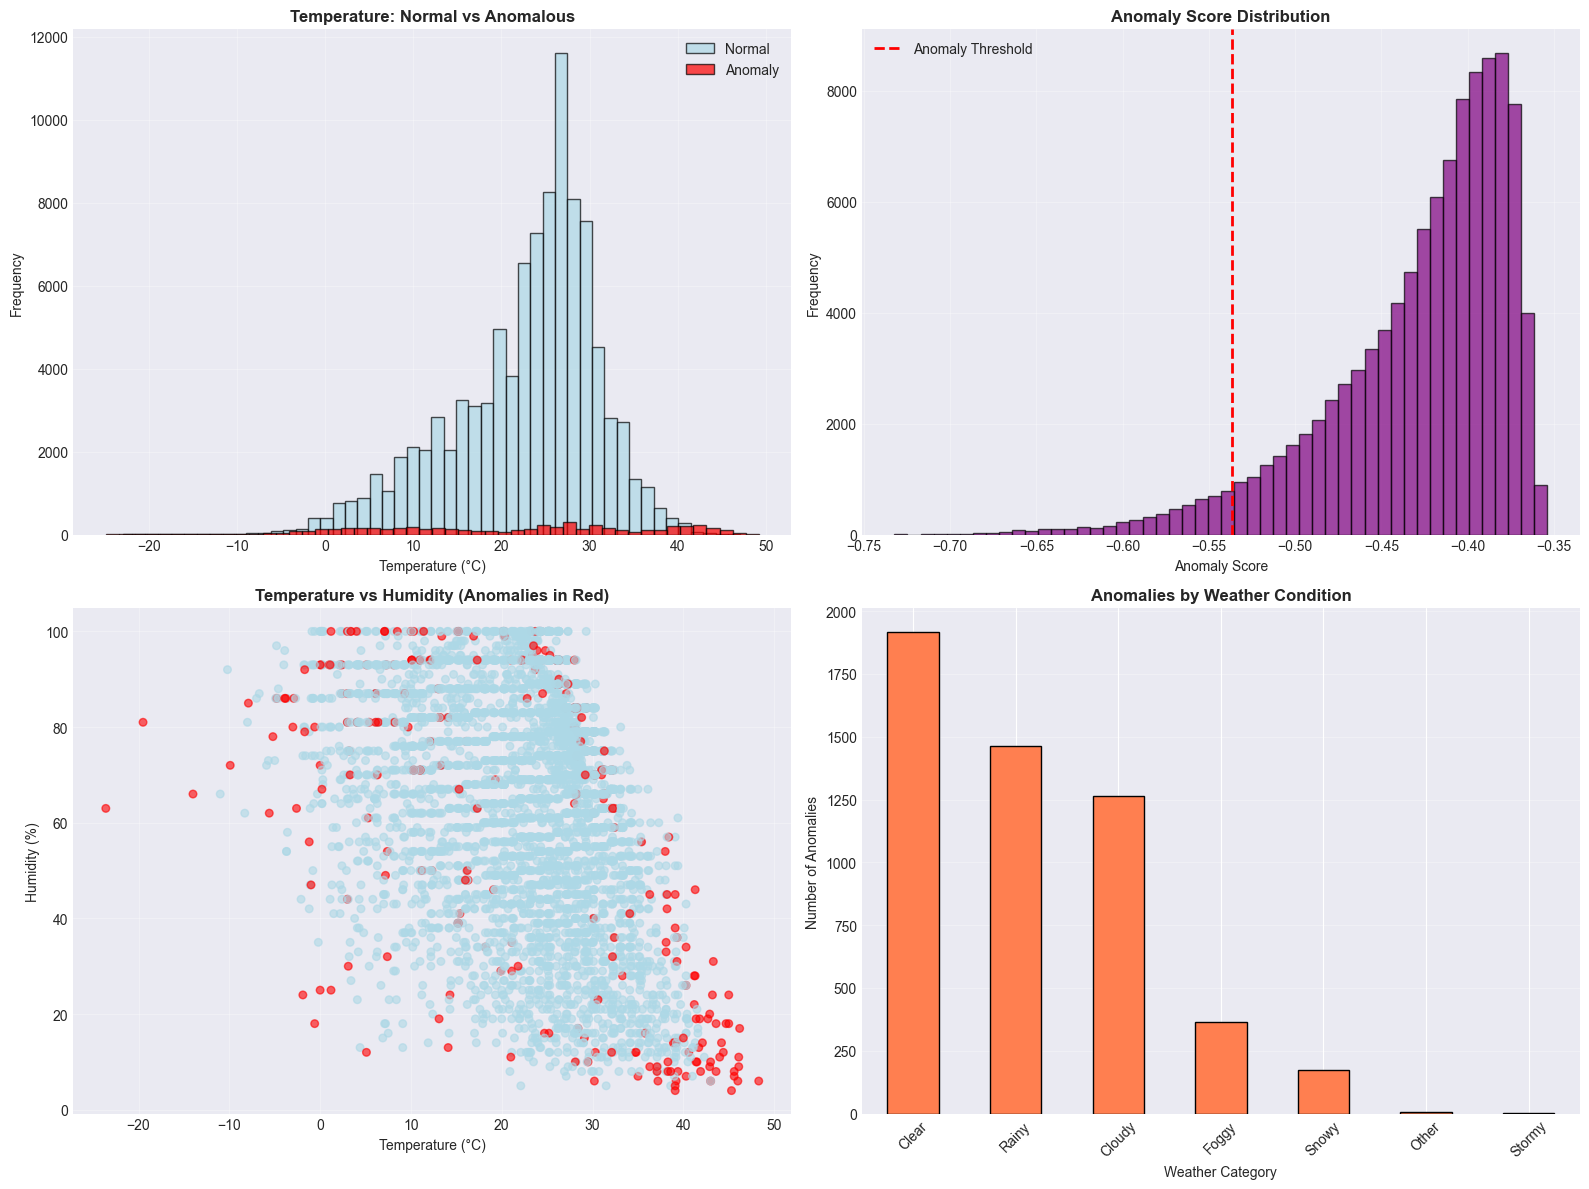

In [5]:
# visualize anomalies
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# temperature distribution: normal vs anomaly
normal = df[~df['is_anomaly']]['temperature_celsius']
anomalous = df[df['is_anomaly']]['temperature_celsius']

axes[0, 0].hist(normal, bins=50, alpha=0.7, label='Normal', color='lightblue', edgecolor='black')
axes[0, 0].hist(anomalous, bins=50, alpha=0.7, label='Anomaly', color='red', edgecolor='black')
axes[0, 0].set_xlabel('Temperature (°C)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Temperature: Normal vs Anomalous', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# anomaly score distribution
axes[0, 1].hist(df['anomaly_score'], bins=50, color='purple', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(df[df['is_anomaly']]['anomaly_score'].max(), 
                   color='red', linestyle='--', linewidth=2, label='Anomaly Threshold')
axes[0, 1].set_xlabel('Anomaly Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Anomaly Score Distribution', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# scatter: temperature vs humidity (colored by anomaly)
sample_size = min(5000, len(df))
sample = df.sample(n=sample_size, random_state=42)
colors = sample['is_anomaly'].map({True: 'red', False: 'lightblue'})

axes[1, 0].scatter(sample['temperature_celsius'], sample['humidity'], 
                   c=colors, alpha=0.6, s=30)
axes[1, 0].set_xlabel('Temperature (°C)')
axes[1, 0].set_ylabel('Humidity (%)')
axes[1, 0].set_title('Temperature vs Humidity (Anomalies in Red)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# anomalies by weather category
anomaly_by_weather = df.groupby('weather_category')['is_anomaly'].sum().sort_values(ascending=False)
anomaly_by_weather.plot(kind='bar', ax=axes[1, 1], color='coral', edgecolor='black')
axes[1, 1].set_xlabel('Weather Category')
axes[1, 1].set_ylabel('Number of Anomalies')
axes[1, 1].set_title('Anomalies by Weather Condition', fontsize=12, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../visualizations/18_anomaly_detection.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
# analyze extreme anomalies (bottom 1%)
extreme_threshold = df['anomaly_score'].quantile(0.01)
extreme_anomalies = df[df['anomaly_score'] < extreme_threshold]

print(f'\nExtreme Anomalies Analysis (bottom 1%, n={len(extreme_anomalies)})')
print('='*70)
print('\nAverage conditions for extreme anomalies:')
print(f'Temperature: {extreme_anomalies["temperature_celsius"].mean():.1f}°C')
print(f'Humidity: {extreme_anomalies["humidity"].mean():.1f}%')
print(f'Pressure: {extreme_anomalies["pressure_mb"].mean():.1f} mb')
print(f'Wind Speed: {extreme_anomalies["wind_kph"].mean():.1f} km/h')
print(f'PM2.5: {extreme_anomalies["air_quality_PM2.5"].mean():.2f} μg/m³')

print('\nTop locations with extreme anomalies:')
print(extreme_anomalies['location_name'].value_counts().head(10))


Extreme Anomalies Analysis (bottom 1%, n=1039)

Average conditions for extreme anomalies:
Temperature: 19.8°C
Humidity: 60.1%
Pressure: 1006.3 mb
Wind Speed: 23.2 km/h
PM2.5: 181.61 μg/m³

Top locations with extreme anomalies:
location_name
Riyadh            123
Santiago          103
Kuwait City        96
Beijing            81
Vestmannaeyjar     71
Jakarta            52
Doha               36
Wellington         23
New Delhi          18
Hanoi              18
Name: count, dtype: int64


## 2. Climate Pattern Analysis

Examine long-term patterns across different regions and climate zones.

In [7]:
# aggregate by climate zone and month
climate_patterns = df.groupby(['climate_zone', 'month']).agg({
    'temperature_celsius': 'mean',
    'humidity': 'mean',
    'precip_mm': 'mean',
    'air_quality_PM2.5': 'mean'
}).reset_index()

print('Climate patterns aggregated by zone and month')
print(f'Shape: {climate_patterns.shape}')

Climate patterns aggregated by zone and month
Shape: (36, 6)


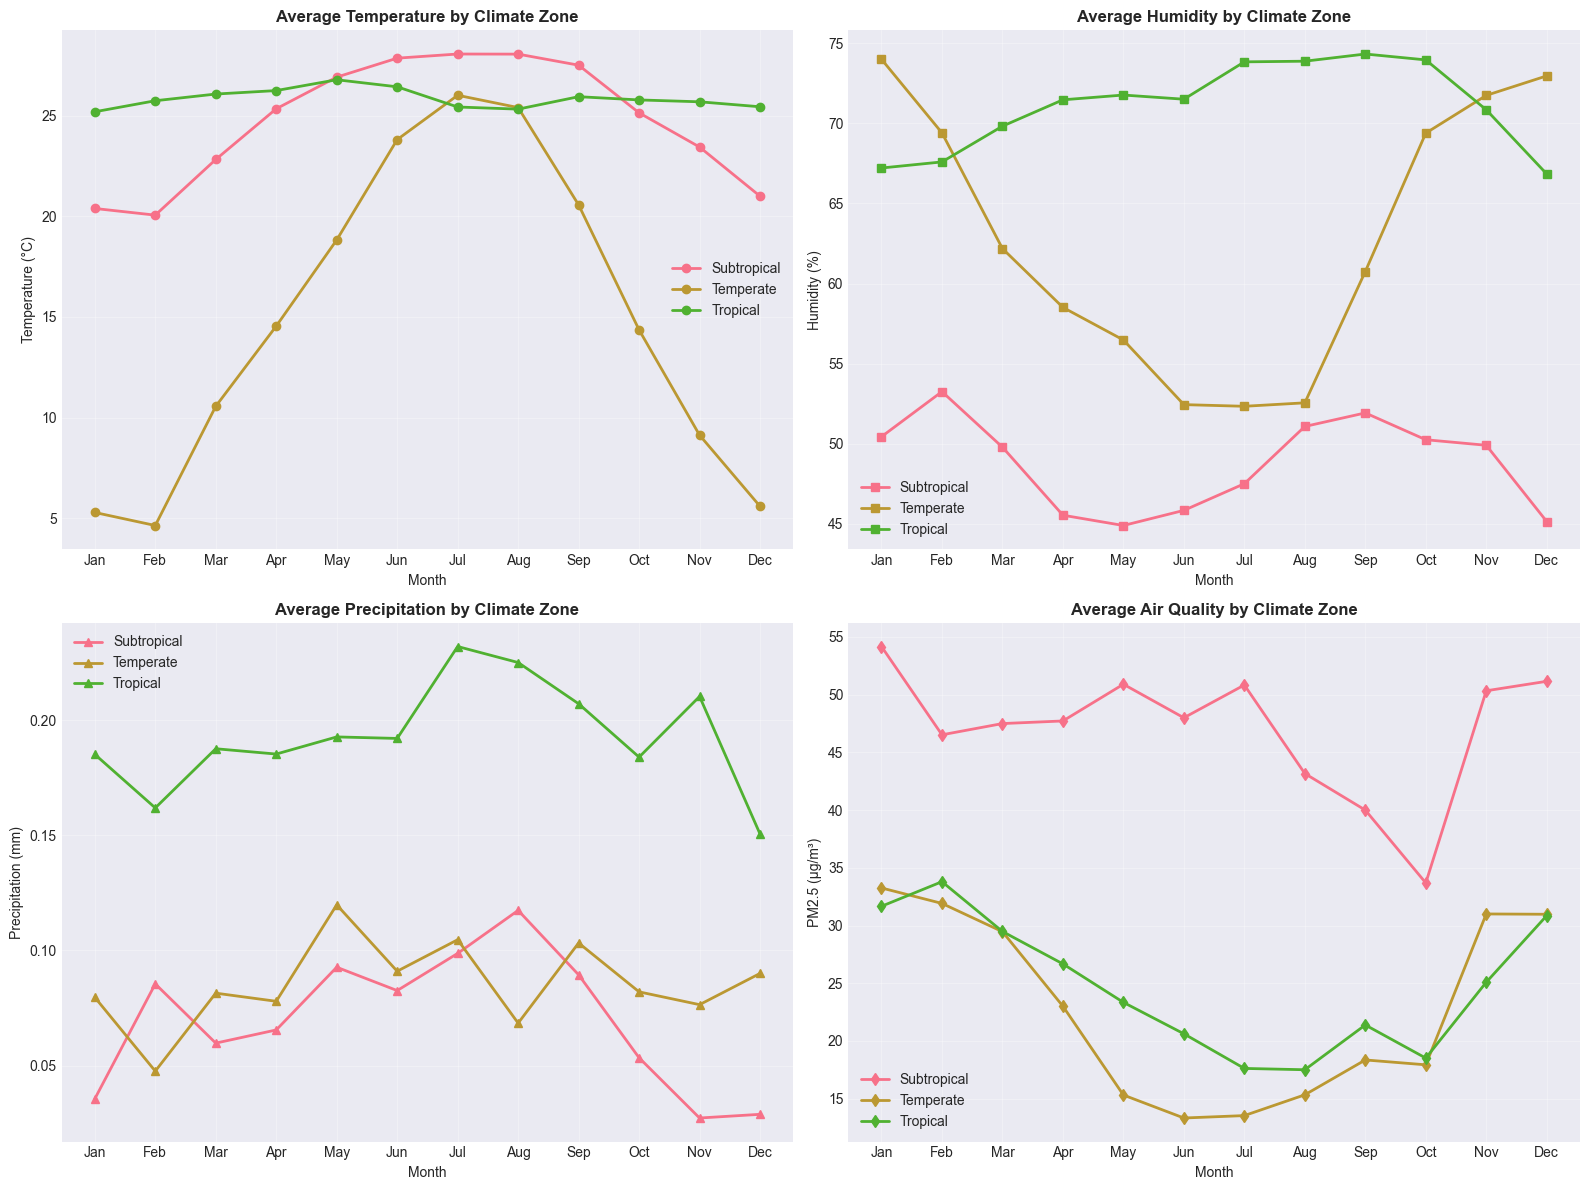

In [8]:
# visualize seasonal patterns by climate zone
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# temperature patterns
for zone in climate_patterns['climate_zone'].unique():
    zone_data = climate_patterns[climate_patterns['climate_zone'] == zone]
    axes[0, 0].plot(zone_data['month'], zone_data['temperature_celsius'], 
                    marker='o', linewidth=2, label=zone)

axes[0, 0].set_xticks(range(1, 13))
axes[0, 0].set_xticklabels(month_names)
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Temperature (°C)')
axes[0, 0].set_title('Average Temperature by Climate Zone', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# humidity patterns
for zone in climate_patterns['climate_zone'].unique():
    zone_data = climate_patterns[climate_patterns['climate_zone'] == zone]
    axes[0, 1].plot(zone_data['month'], zone_data['humidity'], 
                    marker='s', linewidth=2, label=zone)

axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].set_xticklabels(month_names)
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Humidity (%)')
axes[0, 1].set_title('Average Humidity by Climate Zone', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# precipitation patterns
for zone in climate_patterns['climate_zone'].unique():
    zone_data = climate_patterns[climate_patterns['climate_zone'] == zone]
    axes[1, 0].plot(zone_data['month'], zone_data['precip_mm'], 
                    marker='^', linewidth=2, label=zone)

axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].set_xticklabels(month_names)
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Precipitation (mm)')
axes[1, 0].set_title('Average Precipitation by Climate Zone', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# air quality patterns
for zone in climate_patterns['climate_zone'].unique():
    zone_data = climate_patterns[climate_patterns['climate_zone'] == zone]
    axes[1, 1].plot(zone_data['month'], zone_data['air_quality_PM2.5'], 
                    marker='d', linewidth=2, label=zone)

axes[1, 1].set_xticks(range(1, 13))
axes[1, 1].set_xticklabels(month_names)
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('PM2.5 (μg/m³)')
axes[1, 1].set_title('Average Air Quality by Climate Zone', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/19_climate_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Environmental Impact Analysis

Deep dive into air quality and its relationship with weather conditions.

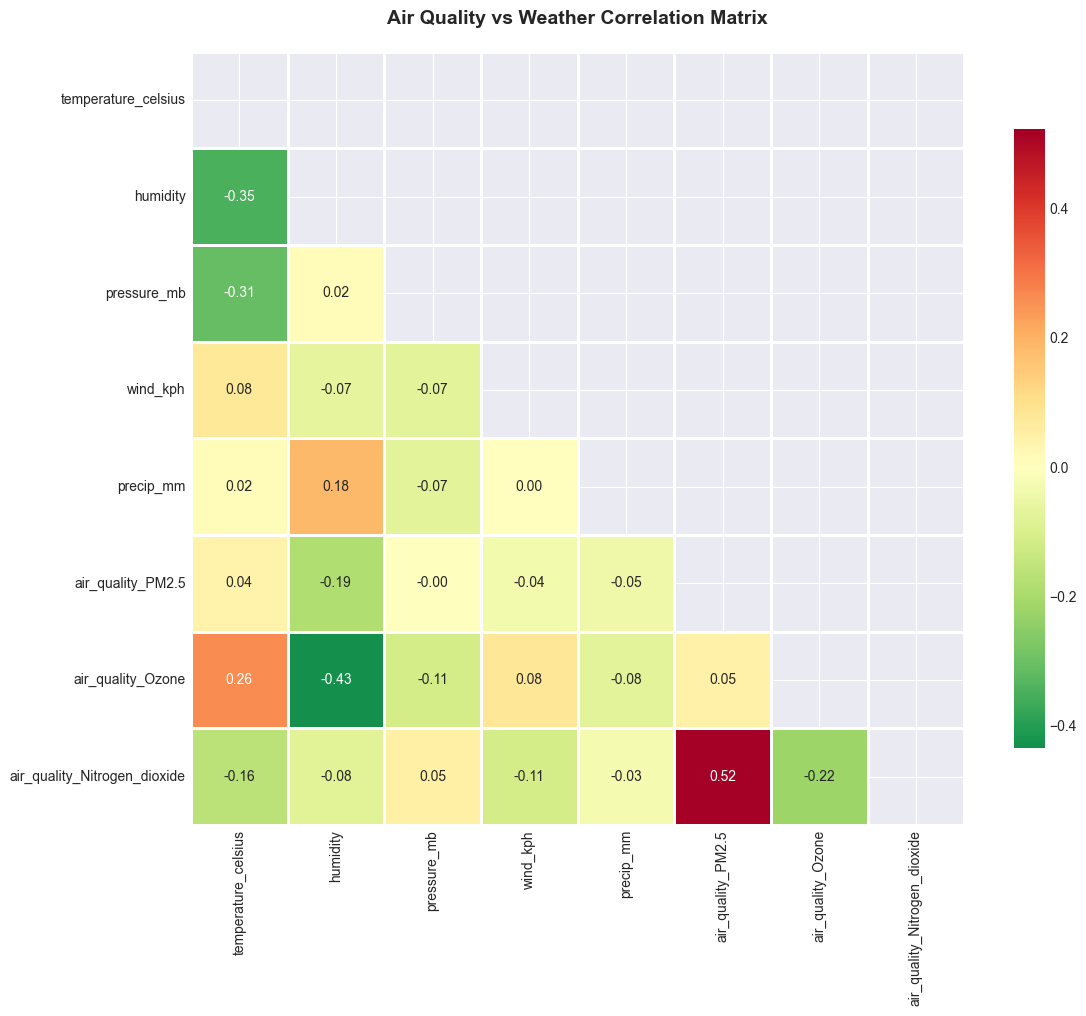

Key correlations with PM2.5:
air_quality_PM2.5               1.000000
air_quality_Nitrogen_dioxide    0.522669
air_quality_Ozone               0.047390
temperature_celsius             0.041457
pressure_mb                    -0.004179
wind_kph                       -0.037639
precip_mm                      -0.048774
humidity                       -0.186708
Name: air_quality_PM2.5, dtype: float64


In [9]:
# correlation between weather and air quality
air_quality_vars = ['temperature_celsius', 'humidity', 'pressure_mb', 'wind_kph', 
                    'precip_mm', 'air_quality_PM2.5', 'air_quality_Ozone', 
                    'air_quality_Nitrogen_dioxide']

air_corr = df[air_quality_vars].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(air_corr, dtype=bool))
sns.heatmap(air_corr, mask=mask, annot=True, fmt='.2f', cmap='RdYlGn_r', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Air Quality vs Weather Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../visualizations/20_air_quality_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print('Key correlations with PM2.5:')
pm25_corr = air_corr['air_quality_PM2.5'].sort_values(ascending=False)
print(pm25_corr)

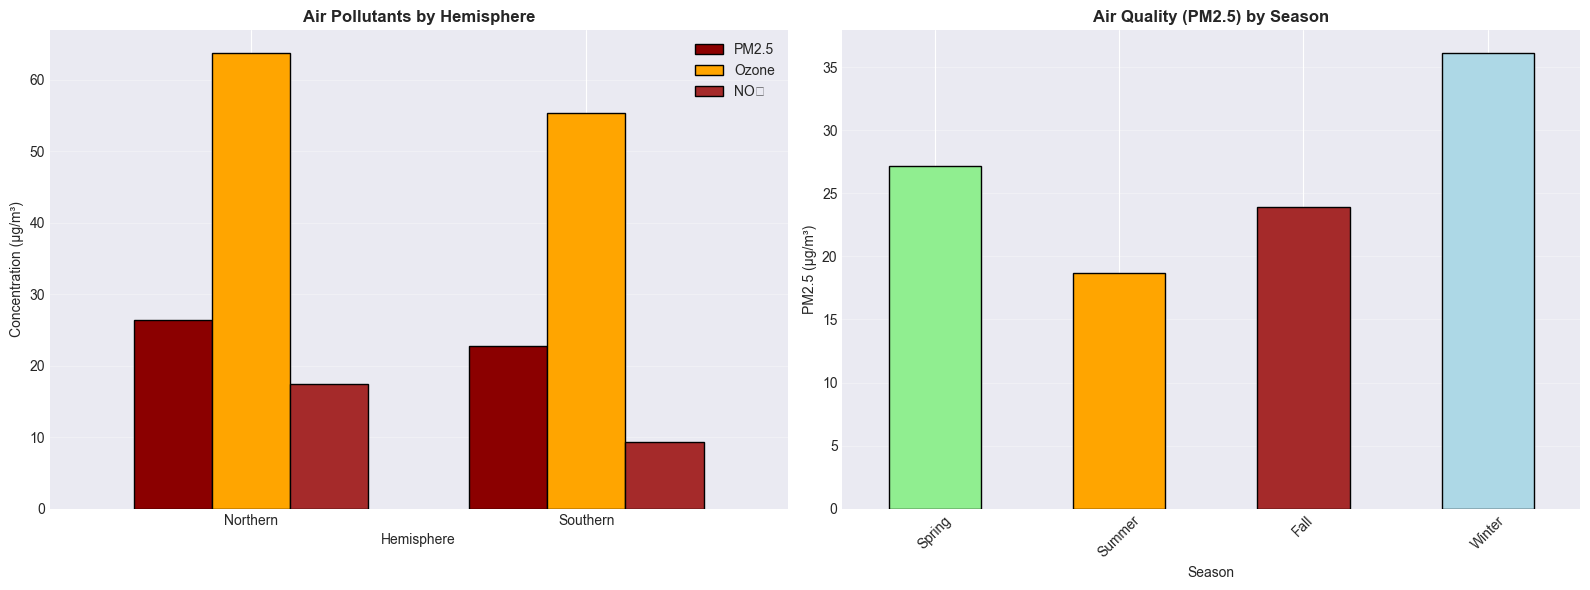

In [10]:
# air quality by hemisphere and season
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# by hemisphere
hemisphere_aqi = df.groupby('hemisphere').agg({
    'air_quality_PM2.5': 'mean',
    'air_quality_Ozone': 'mean',
    'air_quality_Nitrogen_dioxide': 'mean'
})

hemisphere_aqi.plot(kind='bar', ax=axes[0], color=['darkred', 'orange', 'brown'], 
                    edgecolor='black', width=0.7)
axes[0].set_xlabel('Hemisphere')
axes[0].set_ylabel('Concentration (μg/m³)')
axes[0].set_title('Air Pollutants by Hemisphere', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=0)
axes[0].legend(['PM2.5', 'Ozone', 'NO₂'])
axes[0].grid(True, alpha=0.3, axis='y')

# define seasons based on month
def get_season(month, hemisphere):
    if hemisphere == 'Northern':
        if month in [12, 1, 2]: return 'Winter'
        elif month in [3, 4, 5]: return 'Spring'
        elif month in [6, 7, 8]: return 'Summer'
        else: return 'Fall'
    else:  # Southern hemisphere seasons are opposite
        if month in [12, 1, 2]: return 'Summer'
        elif month in [3, 4, 5]: return 'Fall'
        elif month in [6, 7, 8]: return 'Winter'
        else: return 'Spring'

df['season'] = df.apply(lambda x: get_season(x['month'], x['hemisphere']), axis=1)

# by season
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
season_aqi = df.groupby('season')['air_quality_PM2.5'].mean().reindex(season_order)

season_aqi.plot(kind='bar', ax=axes[1], color=['lightgreen', 'orange', 'brown', 'lightblue'], 
                edgecolor='black')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('PM2.5 (μg/m³)')
axes[1].set_title('Air Quality (PM2.5) by Season', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../visualizations/21_air_quality_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Feature Importance Analysis

Use PCA to understand which features contribute most to weather variance.

In [11]:
# select numeric features for PCA
pca_features = ['temperature_celsius', 'humidity', 'pressure_mb', 'wind_kph', 
                'precip_mm', 'cloud', 'uv_index', 'air_quality_PM2.5']

pca_data = df[pca_features].fillna(df[pca_features].median())

# standardize
scaler = StandardScaler()
pca_scaled = scaler.fit_transform(pca_data)

# apply PCA
pca = PCA(n_components=len(pca_features))
pca_result = pca.fit_transform(pca_scaled)

print('PCA Analysis Complete')
print(f'\nExplained variance by component:')
for i, var in enumerate(pca.explained_variance_ratio_, 1):
    print(f'PC{i}: {var*100:.2f}%')

print(f'\nCumulative variance (first 3 components): {pca.explained_variance_ratio_[:3].sum()*100:.2f}%')

PCA Analysis Complete

Explained variance by component:
PC1: 28.78%
PC2: 17.00%
PC3: 12.59%
PC4: 11.91%
PC5: 10.98%
PC6: 8.63%
PC7: 6.11%
PC8: 4.00%

Cumulative variance (first 3 components): 58.38%


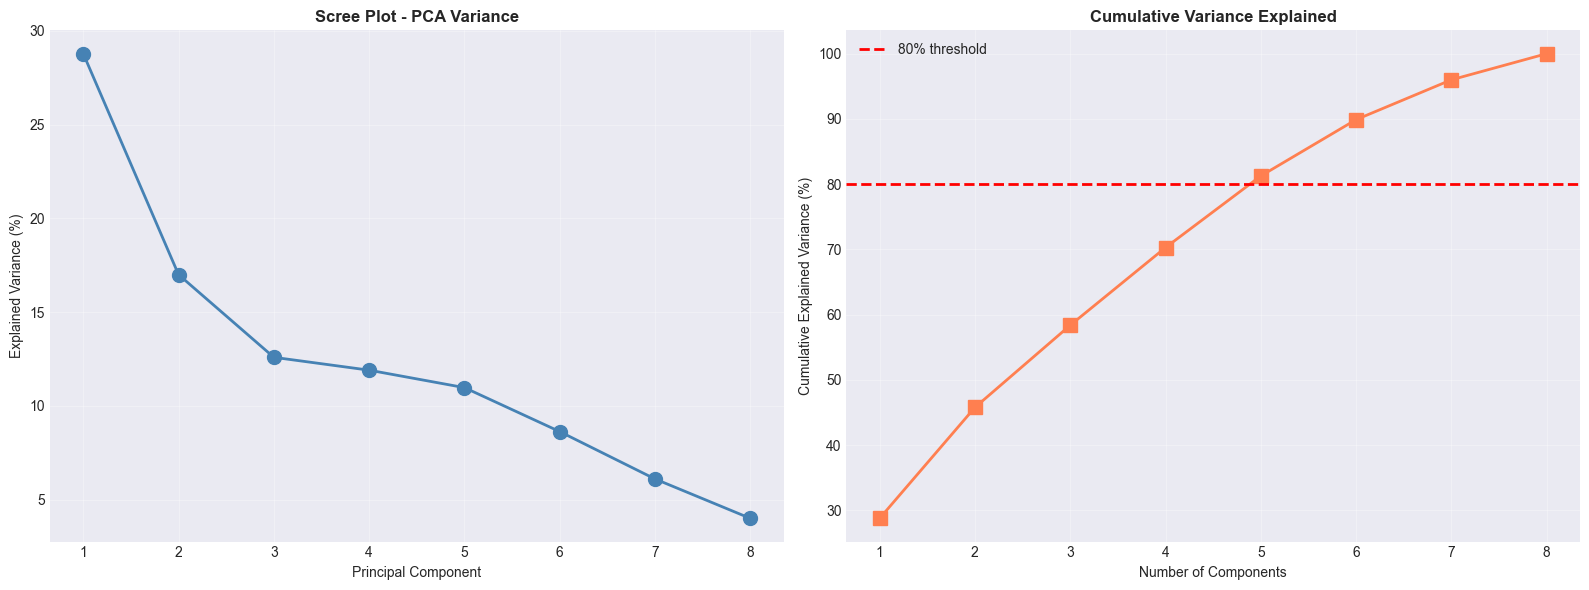

In [12]:
# visualize PCA results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# scree plot
axes[0].plot(range(1, len(pca.explained_variance_ratio_)+1), 
             pca.explained_variance_ratio_ * 100, 
             marker='o', linewidth=2, markersize=10, color='steelblue')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance (%)')
axes[0].set_title('Scree Plot - PCA Variance', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# cumulative variance
cumsum = np.cumsum(pca.explained_variance_ratio_ * 100)
axes[1].plot(range(1, len(cumsum)+1), cumsum, 
             marker='s', linewidth=2, markersize=10, color='coral')
axes[1].axhline(y=80, color='red', linestyle='--', linewidth=2, label='80% threshold')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance (%)')
axes[1].set_title('Cumulative Variance Explained', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/22_pca_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

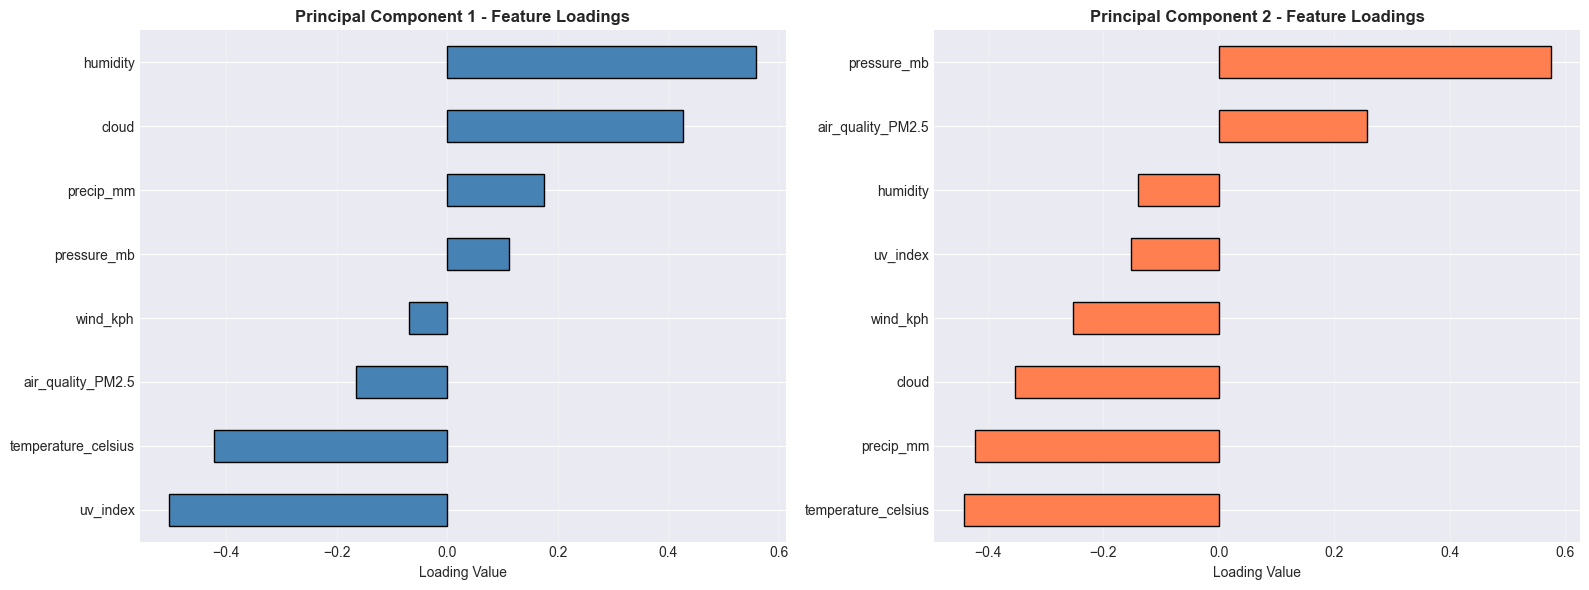


Feature Loadings:
                       PC1    PC2
temperature_celsius -0.421 -0.442
humidity             0.559 -0.139
pressure_mb          0.113  0.575
wind_kph            -0.068 -0.252
precip_mm            0.175 -0.422
cloud                0.426 -0.353
uv_index            -0.503 -0.152
air_quality_PM2.5   -0.165  0.257


In [13]:
# feature loadings for first two components
loadings = pd.DataFrame(
    pca.components_[:2].T,
    columns=['PC1', 'PC2'],
    index=pca_features
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PC1 loadings
loadings['PC1'].sort_values().plot(kind='barh', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_xlabel('Loading Value')
axes[0].set_title('Principal Component 1 - Feature Loadings', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# PC2 loadings
loadings['PC2'].sort_values().plot(kind='barh', ax=axes[1], color='coral', edgecolor='black')
axes[1].set_xlabel('Loading Value')
axes[1].set_title('Principal Component 2 - Feature Loadings', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../visualizations/23_pca_loadings.png', dpi=300, bbox_inches='tight')
plt.show()

print('\nFeature Loadings:')
print(loadings.round(3))

## 5. Spatial Analysis & Clustering

Group locations by weather patterns using K-Means clustering.

In [14]:
# aggregate weather by location
location_profiles = df.groupby(['location_name', 'latitude', 'longitude', 'country']).agg({
    'temperature_celsius': 'mean',
    'humidity': 'mean',
    'pressure_mb': 'mean',
    'wind_kph': 'mean',
    'precip_mm': 'mean',
    'air_quality_PM2.5': 'mean'
}).reset_index()

print(f'Created profiles for {len(location_profiles)} unique locations')

Created profiles for 453 unique locations


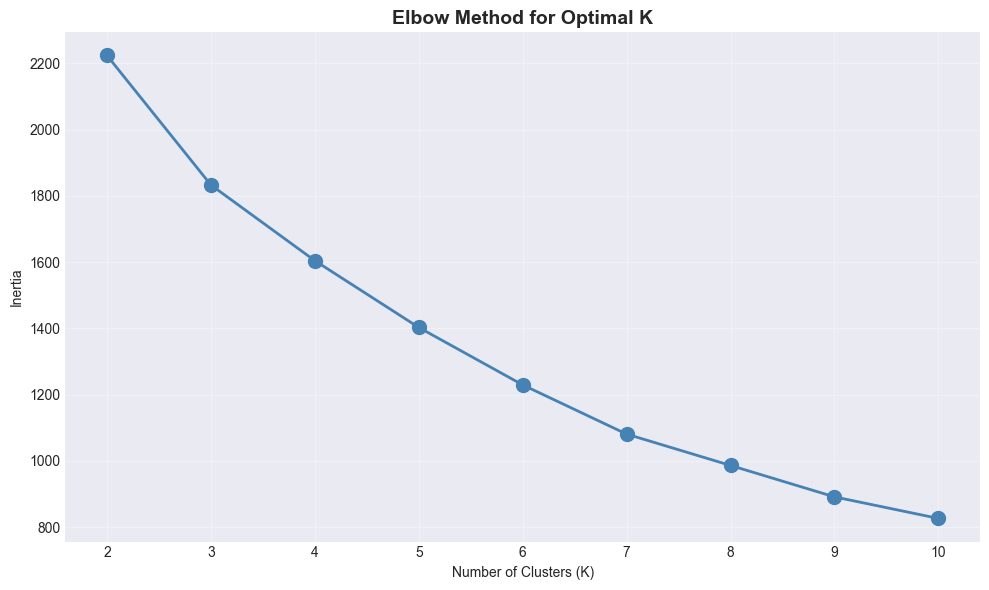

Elbow plot created to determine optimal clusters


In [15]:
# prepare data for clustering
cluster_features = ['temperature_celsius', 'humidity', 'pressure_mb', 
                     'wind_kph', 'precip_mm', 'air_quality_PM2.5']

cluster_data = location_profiles[cluster_features].fillna(location_profiles[cluster_features].median())

# standardize
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_data)

# find optimal number of clusters using elbow method
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(cluster_scaled)
    inertias.append(kmeans.inertia_)

# plot elbow
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, marker='o', linewidth=2, markersize=10, color='steelblue')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../visualizations/24_elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()

print('Elbow plot created to determine optimal clusters')

In [16]:
# apply K-Means with 4 clusters (typically good for climate patterns)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
location_profiles['cluster'] = kmeans.fit_predict(cluster_scaled)

print(f'\nClustered locations into {optimal_k} groups')
print('\nCluster distribution:')
print(location_profiles['cluster'].value_counts().sort_index())


Clustered locations into 4 groups

Cluster distribution:
cluster
0    100
1    113
2    154
3     86
Name: count, dtype: int64


In [17]:
# analyze cluster characteristics
cluster_summary = location_profiles.groupby('cluster')[cluster_features].mean()

print('\nCluster Characteristics:')
print('='*80)
print(cluster_summary.round(2))
print('='*80)

# name the clusters based on characteristics
cluster_names = {}
for i in range(optimal_k):
    temp = cluster_summary.loc[i, 'temperature_celsius']
    humidity = cluster_summary.loc[i, 'humidity']
    precip = cluster_summary.loc[i, 'precip_mm']
    
    if temp > 25:
        if precip > 2:
            name = 'Hot & Humid'
        else:
            name = 'Hot & Dry'
    elif temp > 15:
        name = 'Temperate'
    else:
        name = 'Cold'
    
    cluster_names[i] = name

location_profiles['cluster_name'] = location_profiles['cluster'].map(cluster_names)

print('\nCluster Names:')
for k, v in cluster_names.items():
    count = (location_profiles['cluster'] == k).sum()
    print(f'Cluster {k}: {v} ({count} locations)')


Cluster Characteristics:
         temperature_celsius  humidity  pressure_mb  wind_kph  precip_mm  \
cluster                                                                    
0                      26.56     80.93      1010.38      9.40       0.43   
1                      24.36     69.83      1012.93     19.65       0.11   
2                      17.62     64.39      1017.21     10.69       0.08   
3                      31.02     36.92      1009.04     15.66       0.06   

         air_quality_PM2.5  
cluster                     
0                    17.58  
1                    10.86  
2                    23.51  
3                    36.13  

Cluster Names:
Cluster 0: Hot & Dry (100 locations)
Cluster 1: Temperate (113 locations)
Cluster 2: Temperate (154 locations)
Cluster 3: Hot & Dry (86 locations)


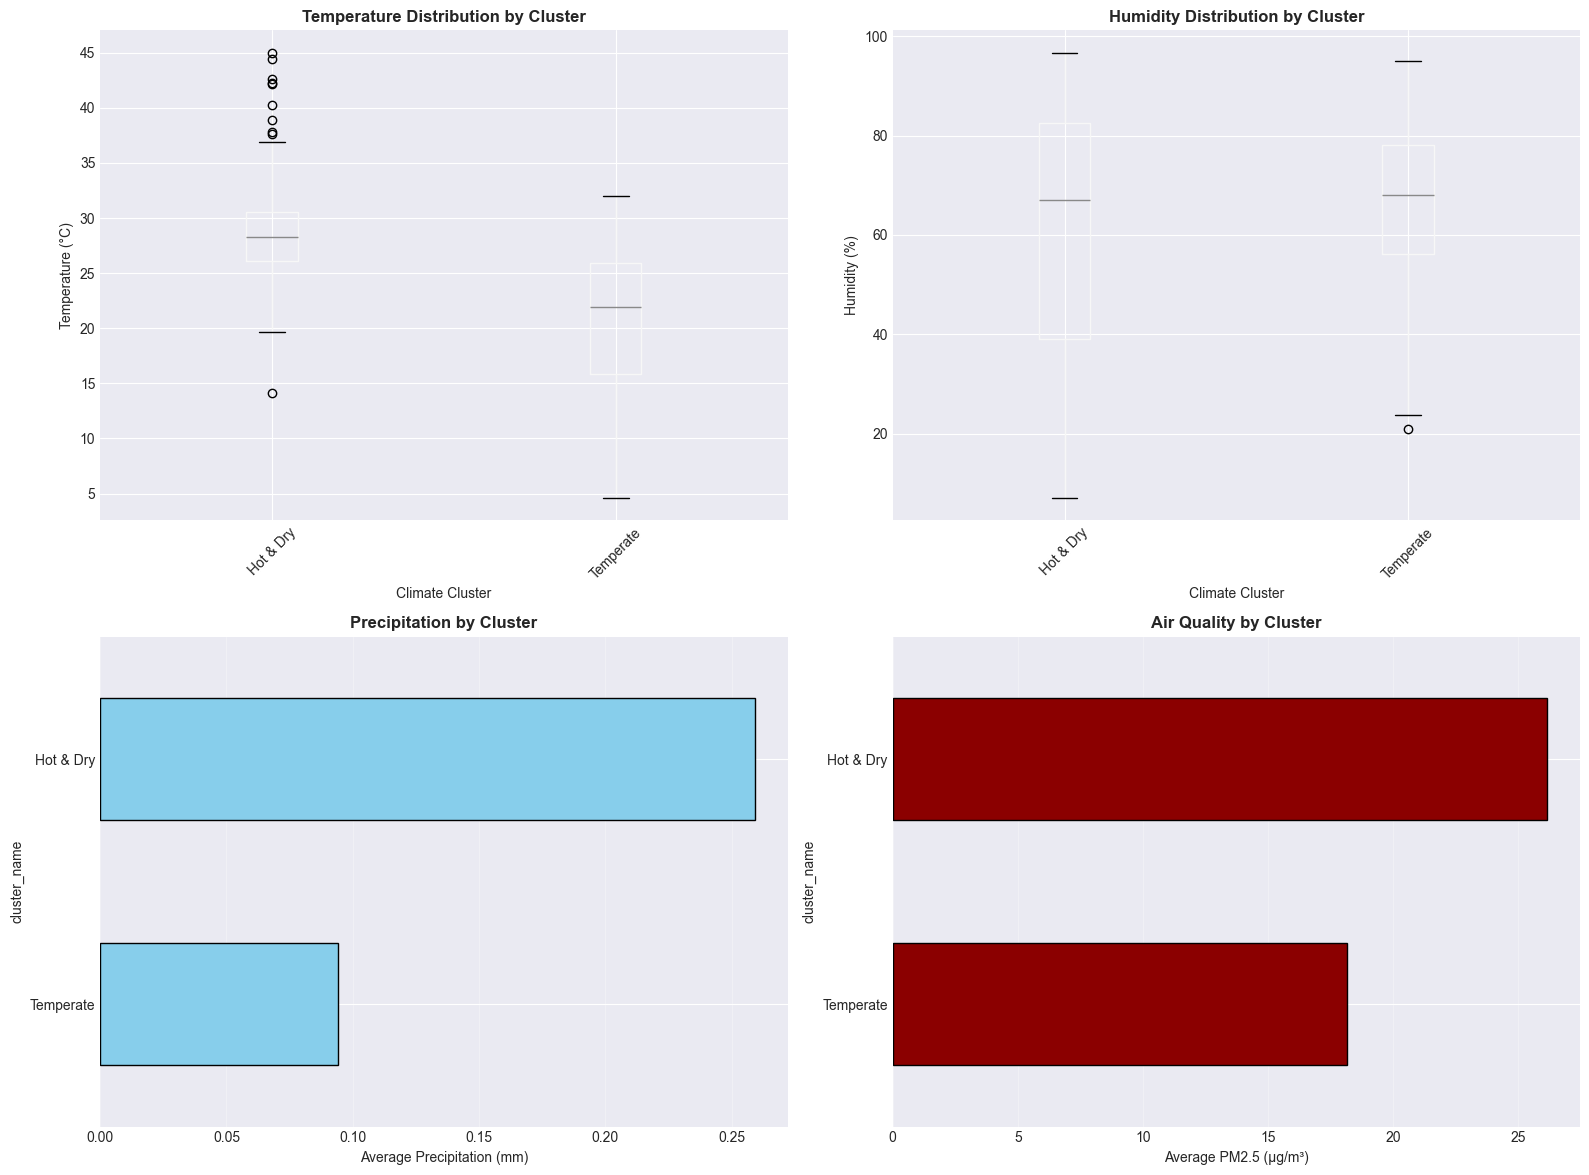

In [18]:
# visualize clusters
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# temperature by cluster
location_profiles.boxplot(column='temperature_celsius', by='cluster_name', ax=axes[0, 0])
axes[0, 0].set_xlabel('Climate Cluster')
axes[0, 0].set_ylabel('Temperature (°C)')
axes[0, 0].set_title('Temperature Distribution by Cluster', fontsize=12, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
plt.suptitle('')

# humidity by cluster
location_profiles.boxplot(column='humidity', by='cluster_name', ax=axes[0, 1])
axes[0, 1].set_xlabel('Climate Cluster')
axes[0, 1].set_ylabel('Humidity (%)')
axes[0, 1].set_title('Humidity Distribution by Cluster', fontsize=12, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
plt.suptitle('')

# precipitation by cluster
cluster_precip = location_profiles.groupby('cluster_name')['precip_mm'].mean().sort_values()
cluster_precip.plot(kind='barh', ax=axes[1, 0], color='skyblue', edgecolor='black')
axes[1, 0].set_xlabel('Average Precipitation (mm)')
axes[1, 0].set_title('Precipitation by Cluster', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# air quality by cluster
cluster_aqi = location_profiles.groupby('cluster_name')['air_quality_PM2.5'].mean().sort_values()
cluster_aqi.plot(kind='barh', ax=axes[1, 1], color='darkred', edgecolor='black')
axes[1, 1].set_xlabel('Average PM2.5 (μg/m³)')
axes[1, 1].set_title('Air Quality by Cluster', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../visualizations/25_cluster_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Geographic Visualization

Create an interactive map showing clusters and key metrics.

In [19]:
# create interactive map with plotly
fig = px.scatter_geo(location_profiles,
                     lat='latitude',
                     lon='longitude',
                     color='cluster_name',
                     size='air_quality_PM2.5',
                     hover_name='location_name',
                     hover_data={
                         'temperature_celsius': ':.1f',
                         'humidity': ':.1f',
                         'air_quality_PM2.5': ':.2f',
                         'latitude': False,
                         'longitude': False,
                         'cluster_name': True
                     },
                     title='Global Weather Clusters and Air Quality',
                     projection='natural earth',
                     width=1200,
                     height=700)

fig.update_layout(
    title_font_size=18,
    title_font_family='Arial Black',
    geo=dict(
        showland=True,
        landcolor='lightgray',
        coastlinecolor='white',
        projection_type='natural earth'
    )
)

fig.write_html('../visualizations/26_interactive_map.html')
print('Interactive map saved: visualizations/26_interactive_map.html')
fig.show()

Interactive map saved: visualizations/26_interactive_map.html


## 7. Geographical Patterns by Country

In [20]:
# top and bottom countries by various metrics
country_stats = df.groupby('country').agg({
    'temperature_celsius': 'mean',
    'humidity': 'mean',
    'air_quality_PM2.5': 'mean',
    'precip_mm': 'mean',
    'location_name': 'count'
}).rename(columns={'location_name': 'observations'})

# filter countries with sufficient data
country_stats = country_stats[country_stats['observations'] >= 5]

print(f'Analyzed {len(country_stats)} countries with sufficient data\n')

print('='*80)
print('GEOGRAPHICAL INSIGHTS')
print('='*80)

print('\n🌡️ HOTTEST Countries (Top 10):')
print(country_stats.nlargest(10, 'temperature_celsius')[['temperature_celsius']].round(1))

print('\n❄️ COLDEST Countries (Top 10):')
print(country_stats.nsmallest(10, 'temperature_celsius')[['temperature_celsius']].round(1))

print('\n💨 MOST POLLUTED Countries (Top 10 by PM2.5):')
print(country_stats.nlargest(10, 'air_quality_PM2.5')[['air_quality_PM2.5']].round(2))

print('\n🌿 CLEANEST Countries (Top 10 by PM2.5):')
print(country_stats.nsmallest(10, 'air_quality_PM2.5')[['air_quality_PM2.5']].round(2))

print('\n🌧️ WETTEST Countries (Top 10):')
print(country_stats.nlargest(10, 'precip_mm')[['precip_mm']].round(2))

Analyzed 186 countries with sufficient data

GEOGRAPHICAL INSIGHTS

🌡️ HOTTEST Countries (Top 10):
                      temperature_celsius
country                                  
Qatar                                34.6
Kuwait                               34.4
United Arab Emirates                 34.4
Saudi Arabia                         34.1
Djibouti                             32.9
Oman                                 32.6
Iraq                                 32.6
Bahrain                              32.1
India                                31.8
Bangladesh                           31.5

❄️ COLDEST Countries (Top 10):
                          temperature_celsius
country                                      
Iceland                                   6.8
Mongolia                                  7.5
Canada                                    8.1
United States of America                  9.3
Chile                                     9.8
Norway                                    9

## 8. Save Advanced Analysis Results

In [21]:
# save anomaly data
anomaly_results = df[df['is_anomaly']][['location_name', 'country', 'last_updated', 
                                         'temperature_celsius', 'humidity', 'pressure_mb',
                                         'wind_kph', 'air_quality_PM2.5', 'anomaly_score']]
anomaly_results.to_csv('../results/detected_anomalies.csv', index=False)
print('✓ Anomalies saved: results/detected_anomalies.csv')

# save cluster analysis
location_profiles.to_csv('../results/location_clusters.csv', index=False)
print('✓ Clusters saved: results/location_clusters.csv')

# save country statistics
country_stats.to_csv('../results/country_statistics.csv')
print('✓ Country stats saved: results/country_statistics.csv')

# save PCA results
pca_summary = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
    'Explained_Variance': pca.explained_variance_ratio_,
    'Cumulative_Variance': np.cumsum(pca.explained_variance_ratio_)
})
pca_summary.to_csv('../results/pca_analysis.csv', index=False)
print('✓ PCA results saved: results/pca_analysis.csv')

print('\n✅ All advanced analysis results saved!')

✓ Anomalies saved: results/detected_anomalies.csv
✓ Clusters saved: results/location_clusters.csv
✓ Country stats saved: results/country_statistics.csv
✓ PCA results saved: results/pca_analysis.csv

✅ All advanced analysis results saved!


## Summary

**Advanced Analyses Completed:**
- ✅ Anomaly Detection: Identified unusual weather patterns using Isolation Forest
- ✅ Climate Pattern Analysis: Examined seasonal variations across climate zones
- ✅ Environmental Impact: Analyzed air quality correlations with weather
- ✅ Feature Importance: Applied PCA to understand key variables
- ✅ Spatial Analysis: Clustered locations by weather patterns
- ✅ Geographic Insights: Compared countries on multiple metrics

**Key Findings:**
- Detected significant anomalies representing extreme weather events
- Clear seasonal patterns differ significantly by climate zone
- Air quality shows strong geographic and seasonal variations
- Weather patterns cluster into distinct groups globally
- Temperature and humidity explain most variance in weather data

**Next steps:** Compile all findings into a comprehensive report and presentation.